In [115]:
# load required packages
import pandas as pd
import numpy as np

import seaborn as sns
from plotnine import (ggplot, aes, geom_bar, xlab, ylab, theme_minimal, ggtitle, geom_line,
                      geom_boxplot, facet_wrap, scale_fill_manual, coord_flip, scale_x_discrete
)
import plotnine.options as ggplot_options
from utilities.plot_utilities import plot_average_rides_count_per_week, plot_bikers_count_by_temp

ggplot_options.figure_size = (6, 3)

In [2]:
BIKES_FILENAME = "../data/processed/bikes_2016_02.csv"
WEATHER_FILENAME = "../data/processed/weather_2016_02.csv"

# load our datasets
bikes_df = pd.read_csv(BIKES_FILENAME)
weather_df = pd.read_csv(WEATHER_FILENAME)

# cast bikes dates correct types
bikes_df['starttime'] = pd.to_datetime(bikes_df['starttime'])
bikes_df['stoptime'] = pd.to_datetime(bikes_df['stoptime'])

# cast weather dates correct types
weather_df['date'] = pd.to_datetime(weather_df['date'])

# attach whether its weekday or weekend
bikes_df['day_type'] = np.where(bikes_df['starttime'].dt.weekday < 5, 'Weekday', 'Weekend')

# join our two datasets
weatherly_bikes_df = pd.merge(left=bikes_df, right=weather_df, left_on='day', right_on='day')

In [50]:
# TODO: move those to a preprocessing step (IDA)
# attach helper columns
weatherly_bikes_df['minimum_temperature_C'] = (weatherly_bikes_df['minimum temperature'] - 32) * 5/9
weatherly_bikes_df['maximum_temperature_C'] = (weatherly_bikes_df['maximum temperature'] - 32) * 5/9
weatherly_bikes_df['average_temperature_C'] = (weatherly_bikes_df['average temperature'] - 32) * 5/9

weatherly_bikes_df['precipitation'] = weatherly_bikes_df['precipitation'].replace({'T': 0}).astype(float)
weather_df['precipitation'] = weather_df['precipitation'].replace({'T': 0}).astype(float)

weatherly_bikes_df['snow fall'] = weatherly_bikes_df['snow fall'].replace({'T': 0}).astype(float)
weather_df['snow fall'] = weather_df['snow fall'].replace({'T': 0}).astype(float)

weatherly_bikes_df['snow depth'] = weatherly_bikes_df['snow depth'].replace({'T': 0}).astype(float)
weather_df['snow depth'] = weather_df['snow depth'].replace({'T': 0}).astype(float)

# attach helper columns
weather_df['minimum_temperature_C'] = (weather_df['minimum temperature'] - 32) * 5/9
weather_df['maximum_temperature_C'] = (weather_df['maximum temperature'] - 32) * 5/9
weather_df['average_temperature_C'] = (weather_df['average temperature'] - 32) * 5/9

### **Number of riders with respect to different average temperatures**

One thing we can explore is the number of bikers we have for different average temeprature ranges. A problem with that would be that if a temperature range is more frequent during the month, we would be mislead that the particular temperature range is more desirable for riderships.

One way we can fix that is by normalizing with respect to the number of days the particular temperature range has occured.

Text(0, 0.5, 'Number of riders')

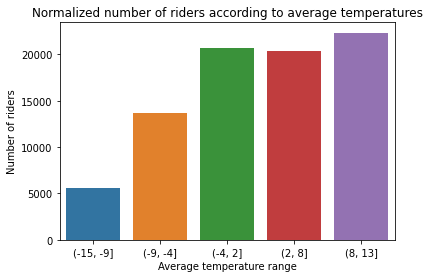

In [20]:
# plot normalized bikers count w.r.t. different temperature ranges
ax = plot_bikers_count_by_temp(weatherly_bikes_df, weather_df, field='average_temperature_C', nbins=6)

# add labels
ax.set_title("Normalized number of riders according to average temperatures")
ax.set_xlabel("Average temperature range")
ax.set_ylabel("Number of riders")

We can see that with increase of the temperature, naturally we have a higher number of riderships.

### **Effect of humidity, precipitation and snow depth to the number of riders.**

/Users/nikolashahpazov/.pyenv/versions/3.9.2/lib/python3.9/site-packages/plotnine/facets/facet.py:396: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


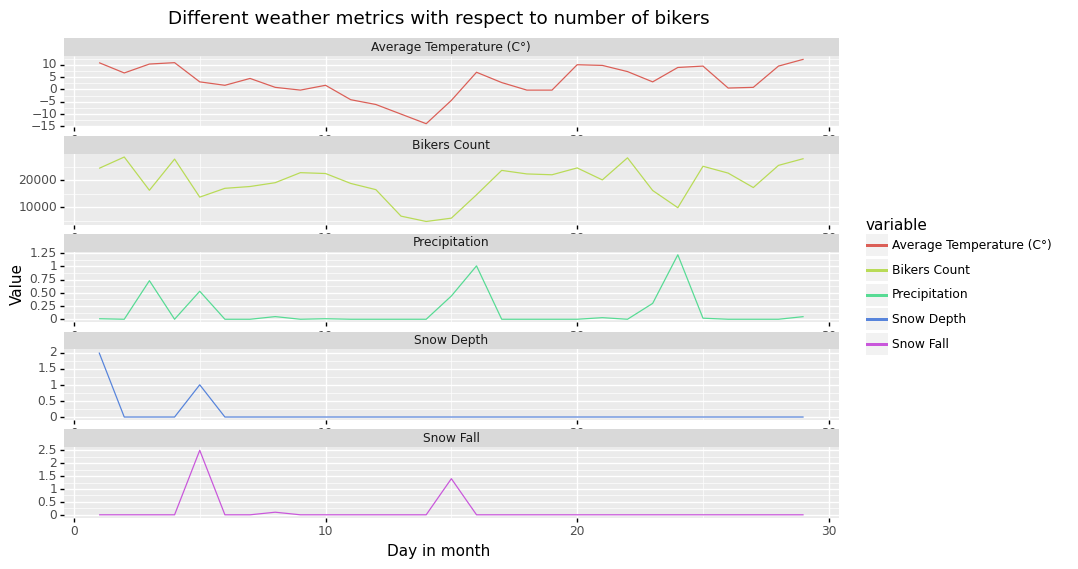

<ggplot: (343285026)>

In [153]:

ggplot_options.figure_size = (10, 6)

METRIC_COLS = ['day', 'average_temperature_C', 'precipitation', 'snow fall', 'snow depth']

daily_bikes_count = (weatherly_bikes_df
 .groupby('day')
 .count()['year']
 .reset_index()
 .rename(columns={'year': 'Bikers Count'})
)

# join with humidity, snowfall, snow depth, temperature
(pd.merge(
    daily_bikes_count,
    weather_df[METRIC_COLS],
    left_on='day',
    right_on='day'
)
.rename(columns={
    'average_temperature_C': 'Average Temperature (C°)',
    'precipitation': 'Precipitation',
    'snow fall': 'Snow Fall',
    'snow depth': 'Snow Depth'
})
# stack the dataframe
.melt(id_vars='day')
# # plot with different facets for different metrics
.pipe(ggplot) +
    aes(x='day', y='value', color='variable') +
    geom_line() +
    facet_wrap('variable', scales='free', nrow=5) +
    xlab("Day in month") +
    ylab("Value") +
    ggtitle("Different weather metrics with respect to number of bikers"))

Again, we can see that with temperature drops and snow fall icrease, we have drops in count of bikers. Other than that, we observe a tradiotional weekly seasonality.

### Linear regression of number of bikers with respect to increase in average temperature